# 3D AutoencoderKL

This demo is a toy example of how to use MONAI's AutoencoderKL. In particular, it uses the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1].

[1] Rombach et. al - ["High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/pdf/2112.10752.pdf)

This tutorial was based on:

[Brain tumor 3D segmentation with MONAI](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

In [ ]:
# TODO: Add Open in Colab

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.cuda.amp import autocast
from tqdm import tqdm

from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpyxyg6wxs


## Download the training set

Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image"],
            pixdim=(2.4, 2.4, 2.2),
            mode=("bilinear"),
        ),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,
    num_workers=4,
    download=False,
    seed=0,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [02:31<00:00,  2.56it/s]

Image shape (1, 96, 96, 64)


## Visualise examples from the training set

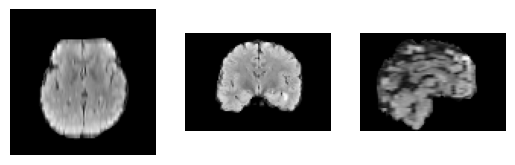

In [6]:
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, channel]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2].rot90(), cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...].rot90(), cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...].rot90(), cmap="gray")

## Download the validation set

In [7]:
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image"],
            pixdim=(2.4, 2.4, 2.2),
            mode=("bilinear"),
        ),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=val_transforms,
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

2022-12-02 09:48:31,454 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-12-02 09:48:31,458 - INFO - File exists: /tmp/tmpyxyg6wxs/Task01_BrainTumour.tar, skipped downloading.
2022-12-02 09:48:31,459 - INFO - Non-empty folder exists in /tmp/tmpyxyg6wxs/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:43<00:00,  2.22it/s]

Image shape (1, 96, 96, 64)


## Define the network

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=32,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
model.to(device)

discriminator = PatchDiscriminator(
    spatial_dims=3,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

Using cuda


PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

In [9]:
perceptual_loss = PerceptualLoss(spatial_dims=3, network_type="squeeze", fake_3d_ratio=0.25)
perceptual_loss.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

optimizer_g = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

## Model training

In [11]:
kl_weight = 1e-6
n_epochs = 30
val_interval = 6
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        # select only one channel from the Decathlon dataset
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        # Generator part
        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = model(images)
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)

            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss) + (adv_weight * generator_loss)

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        # Discriminator part
        with autocast(enabled=True):
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

        scaler_d.scale(loss_d).backward()
        scaler_d.step(optimizer_d)
        scaler_d.update()

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                # select only one channel from the Decathlon dataset
                images = batch["image"].to(device)
                optimizer_g.zero_grad(set_to_none=True)

                reconstruction, z_mu, z_sigma = model(images)
                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = F.l1(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

Epoch 0: 100%|█| 194/194 [04:34<00:00,  1.41s/it, recons_loss=0.023, g
Epoch 1: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.011, g
Epoch 2: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.01, ge
Epoch 3: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00922,
Epoch 4: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.0083, 
Epoch 5: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00767,


epoch 6 val loss: 0.0087


Epoch 6: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00761,
Epoch 7: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00719,
Epoch 8: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00725,
Epoch 9: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00728,
Epoch 10: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00704
Epoch 11: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00702


epoch 12 val loss: 0.0082


Epoch 12: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00656
Epoch 13: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00678
Epoch 14: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00664
Epoch 15: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00653
Epoch 16: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.0064,
Epoch 17: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00591


epoch 18 val loss: 0.0063


Epoch 18: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00638
Epoch 19: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00609
Epoch 20: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00639
Epoch 21: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00623
Epoch 22: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00599
Epoch 23: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00604


epoch 24 val loss: 0.0060


Epoch 24: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00616
Epoch 25: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00563
Epoch 26: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00578
Epoch 27: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.0055,
Epoch 28: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00539
Epoch 29: 100%|█| 194/194 [04:33<00:00,  1.41s/it, recons_loss=0.00563


epoch 30 val loss: 0.0075


## Evaluate the trainig

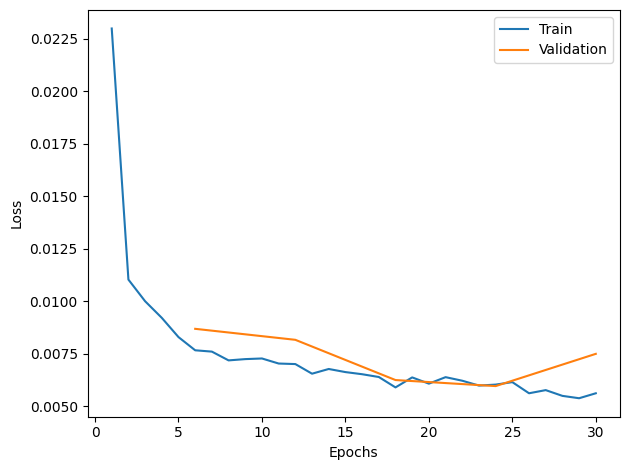

In [12]:
plt.figure()
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, label="Train")
plt.plot(val_samples, val_recon_epoch_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

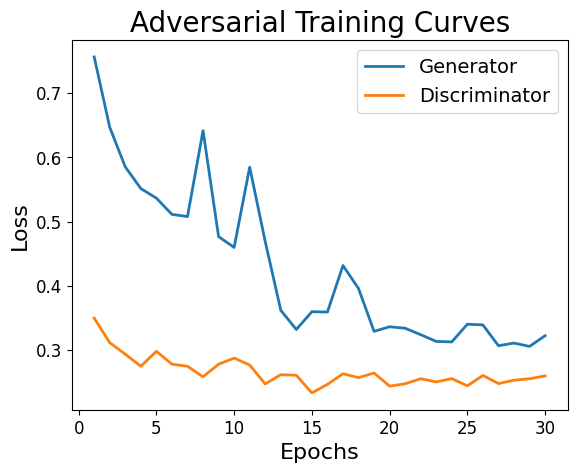

In [13]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise some reconstruction images

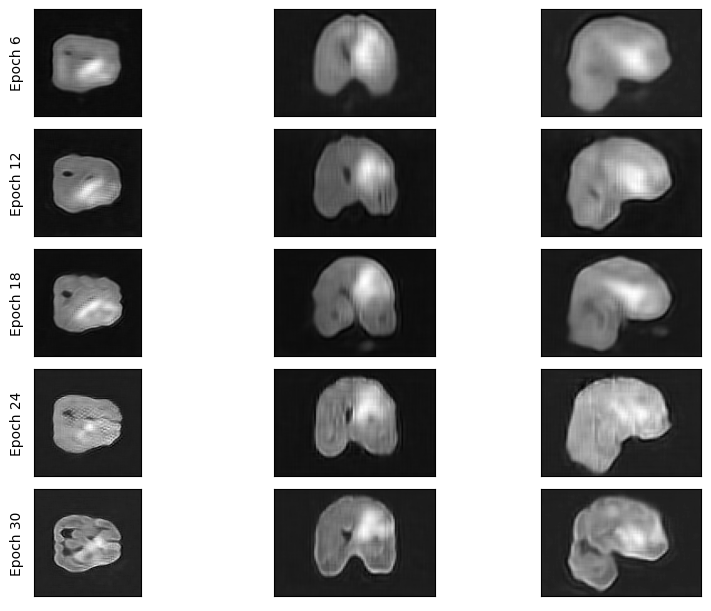

In [14]:
img = check_data["image"][idx, channel]
fig, axs = plt.subplots(nrows=len(intermediary_images), ncols=3, constrained_layout=True, figsize=(8, 6))

# Remove ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for image_n in range(len(intermediary_images)):
    axs[image_n, 0].imshow(intermediary_images[image_n][0, ..., img.shape[2] // 2].cpu(), cmap="gray")
    axs[image_n, 1].imshow(intermediary_images[image_n][0, :, img.shape[1] // 2, ...].cpu().rot90(), cmap="gray")
    axs[image_n, 2].imshow(intermediary_images[image_n][0, img.shape[0] // 2, ...].cpu().rot90(), cmap="gray")
    axs[image_n, 0].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

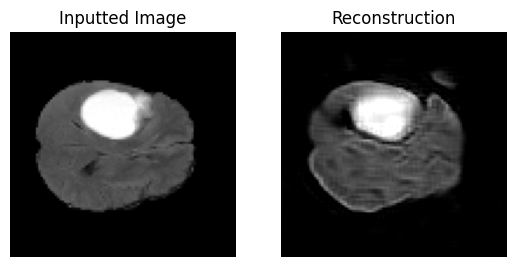

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0, ..., img.shape[2] // 2].cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0, ..., img.shape[2] // 2].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

## Clean up data directory

Remove directory if a temporary storage was used

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)